In [130]:
import os
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
from importlib import reload

import Tree
reload(Tree)
from Tree import *

import forecast_prophet
reload(forecast_prophet)
from forecast_prophet import *

import forecast_arima
reload(forecast_arima)
from forecast_arima import *

import utils
reload(utils)
from utils import *

import main
reload(main)
from main import *

path='c:\\Users\\31683\\Desktop\\data\\M5'
Y_path=path+f"\\sales_train_validation.pkl"  # to data file 
Y_path_eval=path+f"\\sales_train_evaluation.pkl" 
X_path_val_eval=path+f"\\prices_train_val_eval.pkl"  # to data file
df_holidays=pd.read_csv(path+f"\\holidays.csv")

df_data=pd.read_pickle(Y_path)
df_data.drop(columns=['2011-01-29','2011-01-30'],inplace=True) #start on Monday



# mX  = get_mX(X_path_val_eval)

In [147]:
df_data

,state_id,store_id,cat_id,dept_id,2011-01-31,2011-02-01,2011-02-02,2011-02-03,2011-02-04,2011-02-05,...,2016-04-15,2016-04-16,2016-04-17,2016-04-18,2016-04-19,2016-04-20,2016-04-21,2016-04-22,2016-04-23,2016-04-24
0,CA,1,FOODS,1,214,175,182,191,224,263,...,293,317,268,302,237,287,297,331,419,329
1,CA,1,FOODS,2,396,476,354,486,554,747,...,435,499,637,529,391,423,365,489,590,734
2,CA,1,FOODS,3,1398,1607,1496,1730,1915,2952,...,1978,2665,3099,2055,1860,1780,1871,2140,2646,2990
3,CA,1,HOBBIES,1,409,383,263,453,339,750,...,370,690,597,517,461,333,380,471,621,641
4,CA,1,HOBBIES,2,6,9,5,14,7,19,...,31,32,58,25,34,30,30,56,49,73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,WI,3,FOODS,3,1841,1965,1427,2760,2727,3786,...,2534,2659,2449,1991,1715,1579,1670,1897,2411,2233
66,WI,3,HOBBIES,1,228,183,70,285,357,399,...,304,376,200,149,249,202,182,264,381,230
67,WI,3,HOBBIES,2,20,11,4,8,3,13,...,44,35,51,25,27,42,21,32,32,21
68,WI,3,HOUSEHOLD,1,420,327,151,392,492,647,...,676,708,802,609,558,535,573,701,801,766


# Perform CV for a specified forecasting method

In [131]:
transform='log'
dfHolidays=df_holidays
initial=1911-7*50
period=7
horizon=7   
forecast_method='temporal_prophet'
iOoS=7
l_methods=["bottom_up", "top_down_ph" ,"top_down_hp", "wls",
                  "ols" ,'mint_sample','mint_shrink','mint_diag']
l_methods_temporal=["bottom_up", "top_down_ph" ,"top_down_hp","ols","wls_svar" ,
                    "wls_acov", "wls_struct" , "wls_hvar" , "mint_sample", "mint_shrink" ,"mint_diag"]

tree_spatial=Tree( dfData= df_data , sType='spatial') 
dOutputs  = tree_spatial.cross_validation(sTransform=transform, 
                                           dfHolidays=df_holidays, 
                                           iInitial=initial, iPeriod=period, iHorizon=horizon , lMethods=l_methods ,
                                           sForecastMethod=forecast_method)

with open(os.getcwd()+"\\outputs\\ddCVOutputsSpatial_temporal_prophet_cv_log.pkl", "wb") as myFile:
    pickle.dump(dOutputs, myFile)


c:\Users\31683\Desktop\Hierarchical-Forecasting\Tree.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[level]=None


Number of CV folds = 50
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_diag
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_sample
Number of CV folds = 6
wls_svar
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_diag
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.


mint_diag
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
wls_acov
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_sample
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_sample
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.


bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_sample
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_sample
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_sample
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
ols
Number of CV folds = 6
wls_acov
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_sample
Numb

Optimization terminated abnormally. Falling back to Newton.


top_down_hp
Number of CV folds = 6
mint_diag
Number of CV folds = 6
wls_acov
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.


wls_svar


Optimization terminated abnormally. Falling back to Newton.


Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
wls_acov
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_sample
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
wls_acov
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_sample
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_diag
Number of CV folds = 6
mint_diag
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_shrink
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


top_down_hp
Number of CV folds = 6
wls_svar
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


mint_diag
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
wls_svar
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_sample
Number of CV folds = 6
wls_acov
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_sample
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_ph
CV iterations completed = 1 of 50
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_diag
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_sample
Number of CV folds = 6
mint_diag
Number of CV folds = 6
mint_sample
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_sample
Number of CV folds = 6
mint_shrink
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_diag
Number of CV folds = 6
wls_acov
Number of CV folds = 6
mint_sample
Num

Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


mint_sample
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_diag
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
wls_acov
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


top_down_ph
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_sample
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_sample
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_diag
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


mint_sample
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
wls_svar
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_diag
Number of CV folds = 6
wls_acov
Number of CV folds = 6
ols
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.


top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_sample
Number of CV folds = 6
top_down_ph
CV iterations completed = 2 of 50
Number of CV folds = 6
mint_sample
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_diag
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_sample
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_diag
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_diag
Number of CV folds = 6
mint_sample
Number of CV folds = 6
mint_diag
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_diag
Number of CV folds = 6
mint_diag
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_diag
Number o

Optimization terminated abnormally. Falling back to Newton.


top_down_hp
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_sample
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_sample
Number of CV folds = 6
mint_sample
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_shrink
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_sample
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


top_down_hp
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
wls_acov
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


wls_acov
Number of CV folds = 6
mint_sample
Number of CV folds = 6
ols
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


ols
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_sample
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
ols
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_ph
CV iterations completed = 3 of 50
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_diag
Number of CV folds = 6
mint_sample
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds =

Optimization terminated abnormally. Falling back to Newton.


wls_acov
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
wls_acov
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_shrink
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_diag
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


bottom_up
Number of CV folds = 6
wls_acov
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_diag
Number of CV folds = 6
bottom_up
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


top_down_hp
Number of CV folds = 6
ols
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
ols
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_diag
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_sample
Number of CV folds = 6
top_down_hp
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.


top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.


top_down_hp
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_sample
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
ols
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_hp
CV iterations completed = 4 of 50
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_diag
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_diag
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_diag
Number of CV folds = 6
wls_svar
Number of CV folds = 6
bottom_up
Number of CV folds = 6
wls_acov
Number of CV folds = 6
mint_diag
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.


bottom_up
Number of CV folds = 6
wls_acov
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_diag
Number of CV folds = 6
mint_sample
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
wls_acov
Number of CV folds = 6
mint_diag
Number of CV folds = 6
mint_diag
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_sample
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_diag
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.


bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_sample
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_sample
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
ols
Number of CV folds = 6
wls_acov
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_diag
Number

Optimization terminated abnormally. Falling back to Newton.


bottom_up
Number of CV folds = 6
mint_shrink
Number of CV folds = 6
wls_acov
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.


wls_svar
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_sample
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_sample
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
ols
Number of CV folds = 6
mint_diag
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_shrink
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


top_down_hp
Number of CV folds = 6
wls_svar
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


mint_diag
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_diag
Number of CV folds = 6
ols
Number of CV folds = 6
mint_sample
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_ph
CV iterations completed = 5 of 50
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_diag
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_sample
Number of CV folds = 6
mint_diag
Number of CV folds = 6
mint_sample
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_shrink
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_diag
Number of CV folds = 6
mint_sample
Number of CV folds = 6
bottom_up
Number

Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
wls_acov
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_shrink
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
wls_acov
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_diag
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_sample
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.


top_down_ph
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_sample
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_sample
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_diag
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


bottom_up


Optimization terminated abnormally. Falling back to Newton.


Number of CV folds = 6
mint_sample
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
ols
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_diag
Number of CV folds = 6
bottom_up
Number of CV folds = 6
ols
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_shrink
Number of CV folds = 6
top_down_ph
CV iterations completed = 6 of 50
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6

Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


mint_sample
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_sample
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_diag
Number of CV folds = 6
bottom_up
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


wls_acov
Number of CV folds = 6
mint_sample
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.


top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


ols
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
ols
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
wls_svar
CV iterations completed = 7 of 50
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
wls_acov
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
wls_svar
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_sample
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_

Optimization terminated abnormally. Falling back to Newton.


top_down_hp
Number of CV folds = 6
wls_acov
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_diag
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_diag
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.


top_down_hp
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_diag
Number of CV folds = 6
mint_diag
Number of CV folds = 6
mint_sample
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_sample


Optimization terminated abnormally. Falling back to Newton.


Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.


top_down_hp
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_sample
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_hp
CV iterations completed = 8 of 50
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_diag
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_diag
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_sample
Number of CV folds = 6
wls_svar
Number of CV folds = 6
bottom_up
Number of CV folds = 6
wls_acov
Number of CV folds = 6
mint_diag
Number of CV folds = 6
bottom_up
Number of CV folds = 6
wls_acov
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_sample
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
wls_acov
Number of 

Optimization terminated abnormally. Falling back to Newton.


bottom_up


Optimization terminated abnormally. Falling back to Newton.


Number of CV folds = 6
mint_shrink
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.


mint_sample
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_sample
Number of CV folds = 6
mint_diag
Number of CV folds = 6
mint_sample
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.


mint_sample


Optimization terminated abnormally. Falling back to Newton.


Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_sample
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_shrink
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


top_down_ph
Number of CV folds = 6
wls_svar
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.


bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_sample
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_diag
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
CV iterations completed = 9 of 50
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_diag
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_sample
Number of CV folds = 6
mint_diag
Number of CV folds = 6
mint_sample
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_shrink
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_diag
Number of CV folds = 6
mint_sample
Number of CV folds = 6
bottom_up


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_sample
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_diag
Number of CV folds = 6
bottom_up
Number of CV folds = 6
wls_svar
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.


ols
Number of CV folds = 6
mint_shrink
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
ols
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_diag
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
ols
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


bottom_up


Optimization terminated abnormally. Falling back to Newton.


Number of CV folds = 6
ols
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_diag
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
ols
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
wls_acov
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_sample
Number of CV folds = 6
top_down_ph
CV iterations completed = 10 of 50
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds =

Optimization terminated abnormally. Falling back to Newton.


top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
wls_acov
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_diag
Number of CV folds = 6
mint_diag
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


wls_acov
Number of CV folds = 6
mint_shrink
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.


top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


bottom_up


Optimization terminated abnormally. Falling back to Newton.


Number of CV folds = 6
wls_svar
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
ols
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
wls_acov
CV iterations completed = 11 of 50
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
wls_acov
Number of CV folds = 6
bottom_up
Number of CV folds = 6
wls_acov
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
wls_svar
Number of CV folds = 6
wls_acov
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_sample
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_ph
Nu

Optimization terminated abnormally. Falling back to Newton.


top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
wls_svar
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_diag
Number of CV folds = 6
mint_diag
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_diag
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


bottom_up


Optimization terminated abnormally. Falling back to Newton.


Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_diag
Number of CV folds = 6
mint_sample
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_sample
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
wls_svar


Optimization terminated abnormally. Falling back to Newton.


Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.


wls_svar
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_sample
Number of CV folds = 6
wls_acov
Number of CV folds = 6
ols
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
CV iterations completed = 12 of 50
Number of CV folds = 6
mint_diag
Number of CV folds = 6
mint_diag
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_sample
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_sample
Number of CV folds = 6
wls_svar
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_shrink
Number of CV folds = 6
mint_diag
Number of CV folds = 6
bottom_up
Number of CV folds = 6
wls_acov
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
wls_acov
Number of CV folds = 6

Optimization terminated abnormally. Falling back to Newton.


mint_sample
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
wls_acov
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_sample
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_diag
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_sample
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_shrink
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.


top_down_hp
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_sample
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_diag
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_sample
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
CV iterations completed = 13 of 50
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_shrink
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_sample
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up

Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


mint_diag
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
wls_acov
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
wls_acov
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
wls_svar
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_sample
Number of CV folds = 6
mint_shrink
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_sample
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_diag
Number of CV folds = 6
mint_diag
Number o

Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


top_down_hp
Number of CV folds = 6
mint_sample
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_diag
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.


top_down_hp
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
wls_acov
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_ph
CV iterations completed = 14 of 50
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
wls_acov
Number of CV folds = 6
bottom_up
Number of CV folds = 6
wls_acov
Number of CV folds = 6
mint_shrink
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_diag
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_sample
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of 

Optimization terminated abnormally. Falling back to Newton.


Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_diag
Number of CV folds = 6
bottom_up
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


mint_diag
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_diag
Number of CV folds = 6
bottom_up
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.


top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_diag
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


mint_shrink
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
ols
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_hp
CV iterations completed = 15 of 50
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
wls_acov
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of 

Optimization terminated abnormally. Falling back to Newton.


bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_diag
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_shrink
Number of CV folds = 6
mint_shrink
Number of CV folds = 6
mint_diag
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_diag
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.


bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_sample
Number of CV folds = 6
mint_sample
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_sample
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
ols
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_sample
Number of CV folds = 6
wls_acov


Optimization terminated abnormally. Falling back to Newton.


Number of CV folds = 6
ols
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_hp
CV iterations completed = 16 of 50
Number of CV folds = 6
mint_diag
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_sample
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_sample
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
wls_acov
Number of CV folds = 6
mint_diag
Number of CV folds = 6
bottom_up
Number of CV folds = 6
wls_acov
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
wls_acov
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
wls_acov
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_diag
Number of CV folds = 6
mint_sample
Number of CV folds = 6
bottom_up


Optimization terminated abnormally. Falling back to Newton.


wls_acov
Number of CV folds = 6
wls_acov
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_sample
Number of CV folds = 6
ols
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_diag
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_sample
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


wls_acov
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
ols
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.


top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.


top_down_hp
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_sample
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_diag
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
ols
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
CV iterations completed = 17 of 50
Number of CV folds = 6
bottom_up
Number of CV folds = 6
wls_svar
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_diag
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
wls_svar
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
ols
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_shrink
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_diag
Number of CV folds = 6
bottom_up
Number of CV folds = 

Optimization terminated abnormally. Falling back to Newton.


mint_shrink
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_sample
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
wls_acov
Number of CV folds = 6
wls_svar
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
wls_acov
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
wls_svar
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_sample
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.


mint_shrink
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_sample
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_diag
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


top_down_hp
Number of CV folds = 6
mint_diag
Number of CV folds = 6
ols
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_shrink
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_diag
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.


bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_diag
Number of CV folds = 6
wls_acov
Number of CV folds = 6
mint_diag
Number of CV folds = 6
mint_sample
Number of CV folds = 6
top_down_ph
CV iterations completed = 18 of 50
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
wls_acov
Number of CV folds = 6
bottom_up
Number of CV folds = 6
wls_acov
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_diag
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_shrink
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV fol

Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


mint_diag
Number of CV folds = 6
mint_shrink
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_diag
Number of CV folds = 6
bottom_up
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.


top_down_hp
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_diag
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_diag
Number of CV folds = 6
mint_diag
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
CV iterations completed = 19 of 50
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
wls_acov
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_hp
Numb

Optimization terminated abnormally. Falling back to Newton.


top_down_hp
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_diag
Number of CV folds = 6
mint_shrink
Number of CV folds = 6
mint_shrink
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_diag
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.


bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_sample
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
ols
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
wls_acov
Number of CV folds = 6
mint_diag
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
CV iterations completed = 20 of 50
Number of CV folds = 6
mint_diag
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of 

Optimization terminated abnormally. Falling back to Newton.


wls_acov
Number of CV folds = 6
wls_acov
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_sample
Number of CV folds = 6
ols
Number of CV folds = 6
mint_shrink
Number of CV folds = 6
wls_acov
Number of CV folds = 6
mint_sample
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_sample
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


ols
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_sample
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_sample
Number of CV folds = 6
wls_svar
Number of CV folds = 6
mint_sample
Number of CV folds = 6
wls_acov
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
ols
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
CV iterations completed = 21 of 50
Number of CV folds = 6
mint_diag
Number of CV folds = 6
mint_diag
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
wls_acov
Number of CV f

Optimization terminated abnormally. Falling back to Newton.


mint_shrink
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_sample
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_sample
Number of CV folds = 6
wls_svar
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
wls_acov
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_diag
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_sample
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.


mint_shrink
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
wls_acov
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
ols
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.


top_down_hp
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_shrink
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.


bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
wls_acov
Number of CV folds = 6
mint_diag
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
CV iterations completed = 22 of 50
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
wls_acov
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_diag
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV fold

Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


mint_diag
Number of CV folds = 6
mint_shrink
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_diag
Number of CV folds = 6
bottom_up
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.


top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_sample
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


top_down_hp
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
wls_acov
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_ph
CV iterations completed = 23 of 50
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_sample
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
wls_acov
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Num

Optimization terminated abnormally. Falling back to Newton.


Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_shrink
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_sample
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_shrink
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_diag
Number of CV folds = 6
mint_diag
Number of CV folds = 6
bottom_up
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.


mint_diag


Optimization terminated abnormally. Falling back to Newton.


Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
mint_sample
Number of CV folds = 6
ols
Number of CV folds = 6
top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6
mint_shrink
Number of CV folds = 6


Optimization terminated abnormally. Falling back to Newton.


top_down_hp
Number of CV folds = 6
bottom_up
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
mint_diag
Number of CV folds = 6
top_down_ph
Number of CV folds = 6
bottom_up
Number of CV folds = 6


MemoryError: Unable to allocate 10.7 MiB for an array with shape (1000, 1407) and data type float64

In [20]:
transform=None
dfHolidays=df_holidays
initial=1911-7*50
period=7
horizon=7   
forecast_method='prophet'
iOoS=7
l_methods=["bottom_up", "top_down_ph" ,"top_down_hp", "wls",
                  "ols" ,'mint_sample','mint_shrink','mint_diag']
l_methods_temporal=["bottom_up", "top_down_ph" ,"top_down_hp","ols","wls_svar" ,
                    "wls_acov", "wls_struct" , "wls_hvar" , "mint_sample", "mint_shrink" ,"mint_diag"]

tree_spatial=Tree( dfData= df_data , sType='spatial') 
dOutputs  = tree_spatial.cross_validation(sTransform=transform, 
                                           dfHolidays=df_holidays, 
                                           iInitial=initial, iPeriod=period, iHorizon=horizon , lMethods=l_methods ,
                                           sForecastMethod=forecast_method)

with open(os.getcwd()+"\\outputs\\dCVOutputsSpatial_prophet.pkl", "wb") as myFile:
    pickle.dump(dOutputs, myFile)


c:\Users\31683\Desktop\Hierarchical-Forecasting\Tree.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[level]=None


Number of CV folds = 50


KeyError: '0_D'

# Tune

In [ ]:
# import Tree
# reload(Tree)
# from Tree import *

transform=None
dfHolidays=df_holidays
random_size=50
initial=1911-7*50
period=7
horizon=7
sForecastMethod=forecast_method

l_methods=["bottom_up", "top_down_ph" ,"top_down_hp", 'wls', "ols" ,'mint_sample','mint_shrink','mint_diag']
l_methods_temporal=["bottom_up", "top_down_ph" ,"top_down_hp","wls_svar" , "wls_acov",
                    "wls_struct" , "wls_hvar" , "mint_sample", "mint_shrink"]

tree=Tree( dfData= df_data, sType='spatial') 
tree.tune__temporal_prophet(sTransform=transform, iSize=random_size, iInitial=initial, iPeriod=period, iHorizon=horizon , dfHolidays=df_holidays , sForecastMethod=forecast_method )
# output ddParams_timestamp.pkl to data folder


c:\Users\31683\Desktop\Hierarchical-Forecasting\Tree.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[level]=None


Number of CV iterations used for tuning = 11
Tuning has began


Tuning Progress: 100%|██████████| 91/91 [33:27<00:00, 22.06s/it]

Tuning has been terminated succesfully


# Forecast Tree using Prophet

In [172]:
transform='log'
dfHolidays=df_holidays
iOoS=7


tree_spatial=Tree( dfData = df_data , sType='spatial') 
tree_spatial.forecast_prophet(iOoS=iOoS , sTransform=transform, dfHolidays=df_holidays)

slices = [len([sublist for sublist in tree_spatial.list_of_leafs if sublist.count(None) == i]) for i, _ in enumerate(tree_spatial.levels)]
slices.append(1)
 

c:\Users\31683\Desktop\Hierarchical-Forecasting\Tree.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[level]=None


# Plots and Tables

### Compare 3 different spatial hierarchical forecasting methods : Spatial , Spatio Temporal TD and Spatio Temporal CV

In [ ]:

with open(os.getcwd()+'\\outputs\\ddCVOutputsSpatial_prophet_log.pkl', 'rb') as file:
    ddOutputs_spatial = pickle.load(file) 
with open(os.getcwd()+'\\outputs\\ddCVOutputsSpatial_temporal_prophet_tdhp_mYtildeIS_log.pkl', 'rb') as file:
    ddOutputs_spatio_temporal_td = pickle.load(file) 
with open(os.getcwd()+'\\outputs\\ddCVOutputsSpatial_temporal_prophet_cv_mYtildeIS_log.pkl', 'rb') as file:
    ddOutputs_spatio_temporal_cv= pickle.load(file) 
     

with open(os.getcwd()+'\\outputs\\ddCVOutputsSpatial_temporal_prophet_tdhp_40_mYTildeIS_log.pkl', 'rb') as file:
    ddOutputs4= pickle.load(file)    

     

In [16]:
tree=Tree( dfData = df_data , sType='spatial') 
slices = [len([sublist for sublist in tree.list_of_leafs if sublist.count(None) == i]) for i, _ in enumerate(tree.levels)]
slices.append(1)

c:\Users\31683\Desktop\Hierarchical-Forecasting\Tree.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[level]=None


In [128]:
metric='RMSE'

df1=getCVResults( h=1, iOoS=7, ddOutputs=ddOutputs_spatial , metric=metric , slices=slices , rolling=True, relative=False, iters=None)
df2=getCVResults( h=1, iOoS=7, ddOutputs=ddOutputs_spatio_temporal_td , metric=metric , slices=slices , rolling=True, relative=False, iters=None)
df3=getCVResults( h=1, iOoS=7, ddOutputs=ddOutputs_spatio_temporal_cv , metric=metric , slices=slices , rolling=True, relative=False, iters=None)

df4=getCVResults( h=1, iOoS=7, ddOutputs=ddOutputs4 , metric=metric , slices=slices , rolling=True, relative=False, iters=None)
# df5=getCVResults( h=1, iOoS=7, ddOutputs=ddOutputs5 , metric=metric , slices=slices , rolling=True, relative=False, iters=None)
# df6=getCVResults( h=1, iOoS=7, ddOutputs=ddOutputs6 , metric=metric , slices=slices , rolling=True, relative=False, iters=None)



row_tuples = list(itertools.product(df2.index, df2.columns.get_level_values(0).unique()))
row_index=pd.MultiIndex.from_tuples( row_tuples ,names=['Level','Method'])

dfComparison = pd.DataFrame(index=row_index, columns=['Spatial', 'ST-TDHP','ST CV', 'ST_TDHP_i40'])
for i,df in enumerate([df1,df2,df3,df4]): 
    for index in dfComparison.index:
        dfComparison.loc[index][i]=df.loc[index[0],index[1]]

dfComparison

Spatial ST-TDHP   ST CV ST_TDHP_i40
Level   Method                                         
Total   bottom_up   1714.67 1758.14 1393.11     1758.14
        top_down_ph 1461.86 1746.96 1570.73     1364.76
        top_down_hp 1461.86 1746.96 1570.73     1364.76
        wls         1443.98 1751.37 1535.28     1340.62
        ols         1427.67 1804.22 1469.66     1299.67
        mint_sample 1332.23 2235.42 2841.93     1366.72
        mint_shrink 1455.33 1841.78 1427.83     1223.29
        mint_diag   1362.54 1723.39 1377.38     1314.08
State   bottom_up   1485.03 1522.00 1411.65     1522.00
        top_down_ph 1485.58 1867.96 1767.59     1421.91
        top_down_hp 1535.34 1883.55 1792.66     1452.16
        wls         1366.11 1624.16 1503.05     1306.59
        ols         1307.65 1562.62 1421.69     1275.12
        mint_sample 1147.47 1542.81 1995.32     1353.82
        mint_shrink 1131.99 1466.86 1254.63     1288.44
        mint_diag   1204.58 1469.28 1241.85     1260.56
Store   bottom_up   1211.86 1225.75 1102.33     1225.75
        top_down_ph 1542.66 1577.16 1551.12     1399.22
        top_down_hp 1595.26 1622.55 1592.51     1441.55
        wls         1156.03 1389.81 1121.84     1259.43
        ols         1035.26 1258.32 1124.45     1148.43
        mint_sample  913.53 1160.42 1596.36     1011.06
        mint_shrink  895.49 1059.96 1005.52     1002.51
        mint_diag   1003.34 1159.41 1002.41      999.73
Cat.    bottom_up   1090.72 1097.01 1054.15     1097.01
        top_down_ph 1464.27 1544.35 1522.93     1469.08
        top_down_hp 1504.71 1586.51 1564.15     1511.51
        wls         1091.85 1224.93 1111.81     1210.66
        ols          952.78 1115.95  948.51      947.68
        mint_sample  785.06 1049.67 1389.13      875.60
        mint_shrink  809.22  998.13  939.50      891.08
        mint_diag    952.06 1074.12  930.99      901.19
Dept.   bottom_up    922.75  978.77  951.44      978.77
        top_down_ph 1317.99 1400.22 1384.27     1347.86
        top_down_hp 1347.95 1438.19 1416.08     1375.69
        wls         1040.72 1064.65 1115.03     1244.49
        ols          886.67  995.06  931.54      958.08
        mint_sample  683.85  897.52 1241.17      783.10
        mint_shrink  708.22  876.57  863.62      800.62
        mint_diag    797.82  982.54  847.61      809.17
Average bottom_up   3025.17 2998.01 2844.91     2998.01
        top_down_ph 3305.62 3836.38 3631.32     3071.43
        top_down_hp 3378.62 3886.75 3709.02     3125.50
        wls         2866.85 3469.62 2992.90     2977.20
        ols         2751.22 3283.46 2711.24     2571.39
        mint_sample 2117.46 3112.73 4166.15     2415.29
        mint_shrink 2500.02 2820.62 2346.25     2410.28
        mint_diag   2567.69 2912.27 2385.37     2425.11

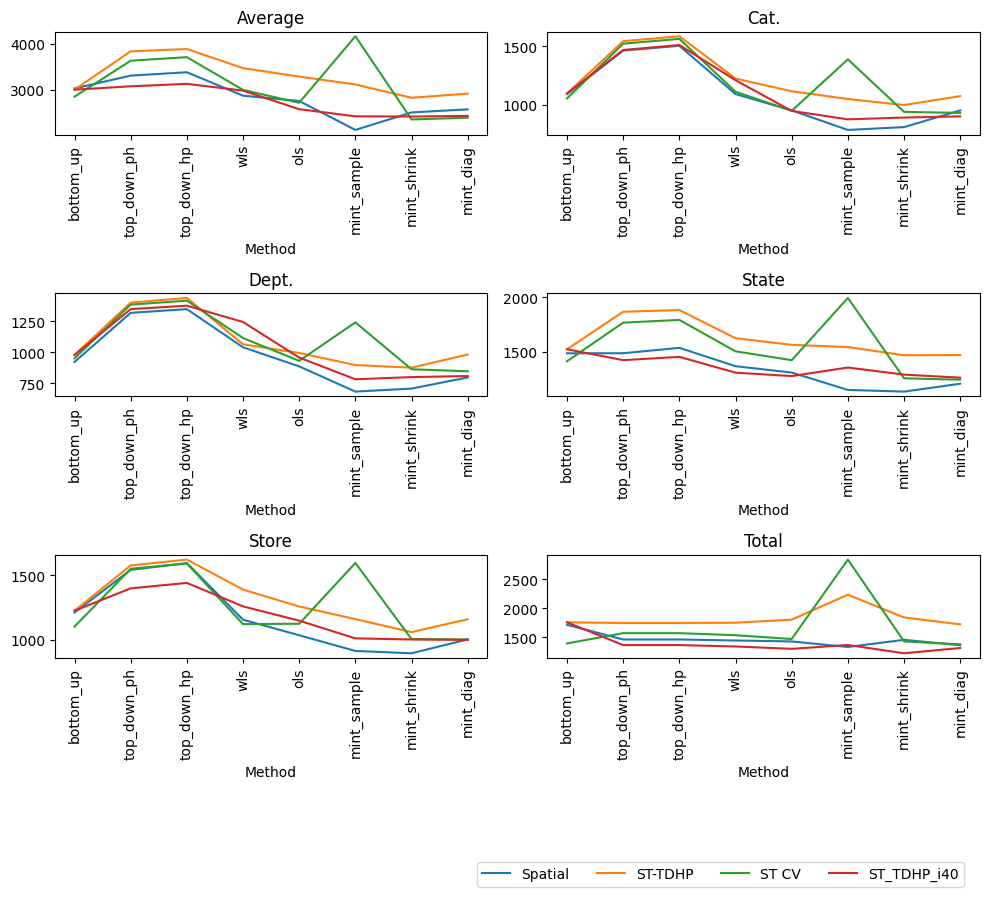

In [129]:
fig, axes = plt.subplots(3, 2, figsize=(10, 8))

# Flatten the axes array to easily iterate through it
axes = axes.flatten()
levels = dfComparison.index.levels[0]
# Plot each dfLevel in the corresponding subplot
for i, level in enumerate(levels):
    # Select the data for the current level
    dfLevel = dfComparison.loc[level]
    
    # Plot the data on the respective subplot
    dfLevel.plot(ax=axes[i], label=level, legend=None)
    
    # Set the title for the subplot
    axes[i].set_title(level)
    
    # Rotate x-ticks for better visibility
    axes[i].tick_params(axis='x', rotation=90)

# Show the plot
plt.tight_layout()
plt.legend(loc='center', bbox_to_anchor=(0.4, -2.1), ncol=6)  # Placing the legend below the grid
plt.show()

### Per iteration plot

In [ ]:

with open(os.getcwd()+'\\outputs\\ddCVOutputs_spatial_prophet_log.pkl', 'rb') as file:
    ddOutputs_spatial = pickle.load(file) 
with open(os.getcwd()+'\\outputs\\ddCVOutputs_spatial_temporal_prophet_td_log.pkl', 'rb') as file:
    ddOutputs_spatio_temporal_td = pickle.load(file) 
with open(os.getcwd()+'\\outputs\\ddCVOutputs_spatial_temporal_prophet_lasso_log.pkl', 'rb') as file:
    ddOutputs_spatio_temporal_lasso = pickle.load(file) 

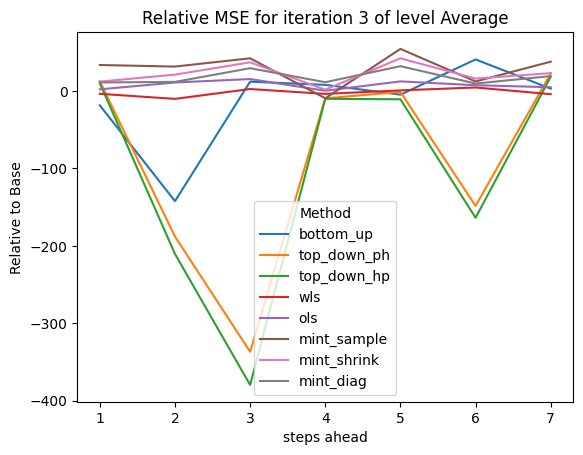

In [ ]:
iter=3


ddOutputs=
horizon=7
relative='Base'
level='Average'
iters=int(dOutputs['bottom_up']['mYhat'].shape[1]/horizon)
metric='MSE'


lMethods=list(dOutputs.keys())
# lMethods.remove('top_down_ph')
# lMethods.remove('top_down_hp')

plt.figure()
for method in lMethods:
    vValues = np.zeros(horizon)
    
    for h in range(1, horizon+1):
        df = getCVResults(h=h, iOoS=horizon,ddOutputs=ddOutputs,  metric=metric, slices=slices, 
                          iters=iter, 
                          rolling=False)[method]
        vValues[h-1] = df[df.index == level][relative].item()    
    plt.plot(np.arange(1,horizon+1), vValues, label=method)

plt.legend(title="Method")
plt.xlabel("steps ahead")
plt.ylabel(f"Relative to {relative}")
plt.title(f"Relative {metric} for iteration {iter} of level {level}")

# Show the plot
plt.show()


### Plot of iterations per h


In [ ]:

with open(os.getcwd()+'\\outputs\\ddCVOutputsSpatial_prophet_log.pkl', 'rb') as file:
    ddOutputs_spatial = pickle.load(file) 
with open(os.getcwd()+'\\outputs\\ddCVOutputsSpatial_temporal_prophet_td_log.pkl', 'rb') as file:
    ddOutputs_spatio_temporal_td = pickle.load(file) 
# with open(os.getcwd()+'\\outputs\\ddCVOutputsSpatial_temporal_prophet_lasso_log.pkl', 'rb') as file:
#     ddOutputs_spatio_temporal_lasso = pickle.load(file) 

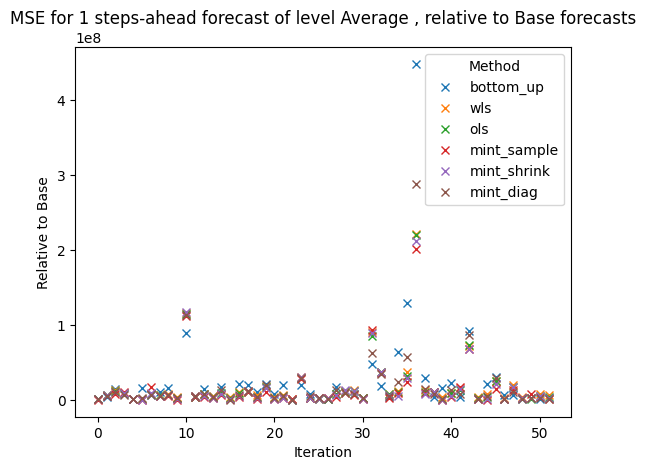

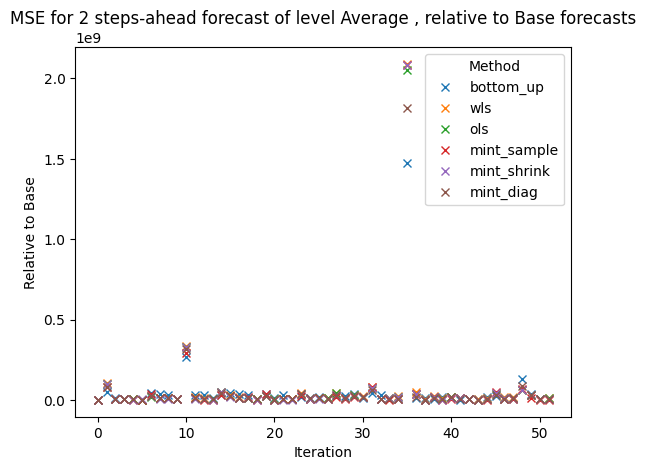

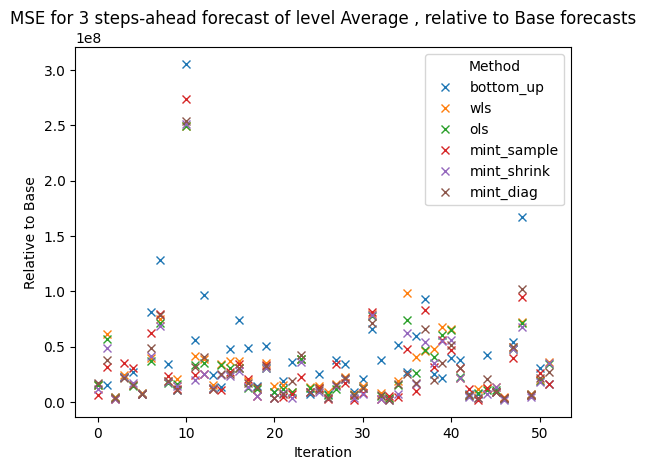

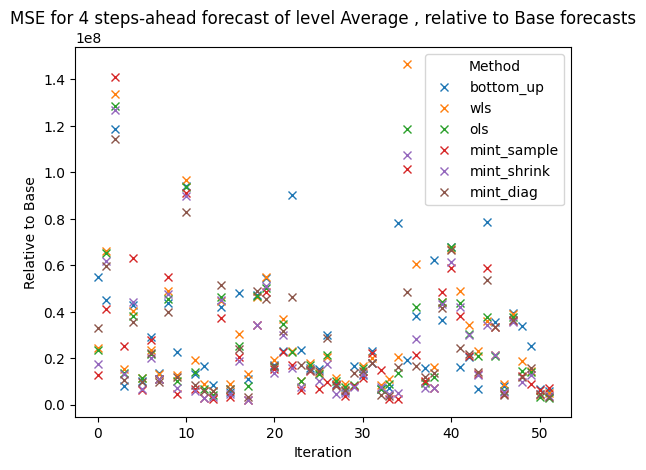

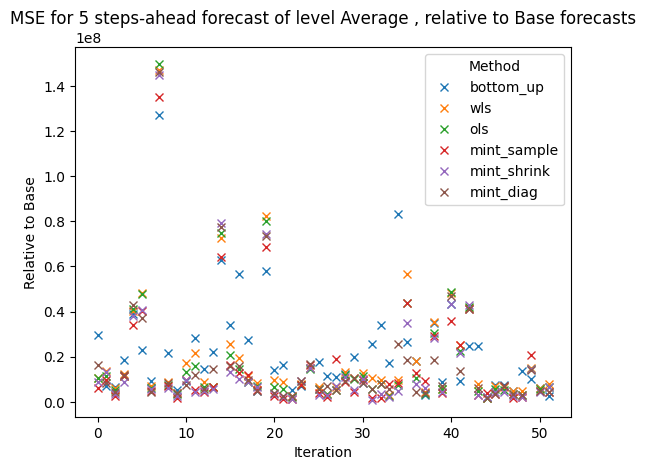

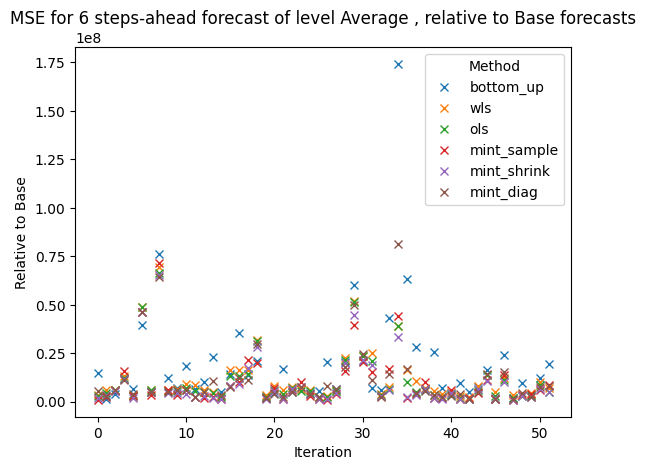

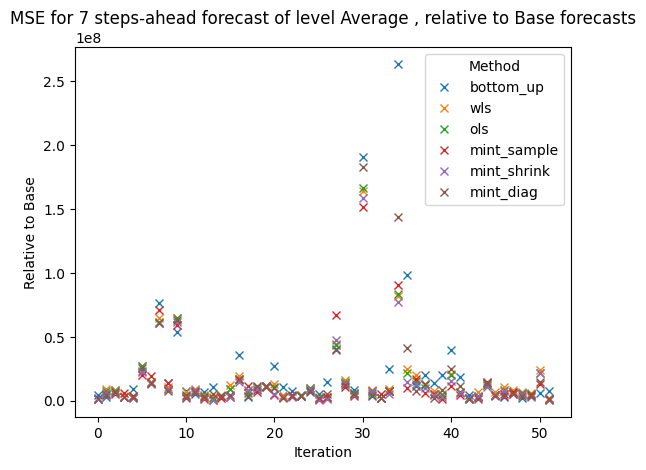

In [ ]:
ddOutputs=ddOutputs_spatial
ddOutputs=ddOutputs_spatio_temporal_td

horizons=[1,2 ,3, 4,  5 , 6 , 7]



horizon=7
relative='Base'
level='Average'
iters=int(ddOutputs['bottom_up']['mYhat'].shape[1]/horizon)
metric='MSE'

lMethods=list(ddOutputs.keys())
lMethods.remove('top_down_ph')
lMethods.remove('top_down_hp')

plt.figure()
for h in horizons:
    for method in lMethods:
        vValues = np.zeros(iters)
        
        for iter in range(1, iters+1):
            df = getCVResults(h=h, iOoS=horizon,ddOutputs=ddOutputs, metric=metric, 
                            slices=slices, 
                            iters=iter, 
                            rolling=False,
                            relative=False)[method]
            vValues[iter-1] = df[df.index == level].item()    
        plt.plot(np.arange(iters), vValues,'x' ,label=method)

    plt.legend(title="Method")
    plt.xlabel("Iteration")
    plt.ylabel(f"Relative to {relative}")
    plt.title(f"{metric} for {h} steps-ahead forecast of level {level} , relative to {relative} forecasts")

    # Show the plot
    plt.show()

    
    
    



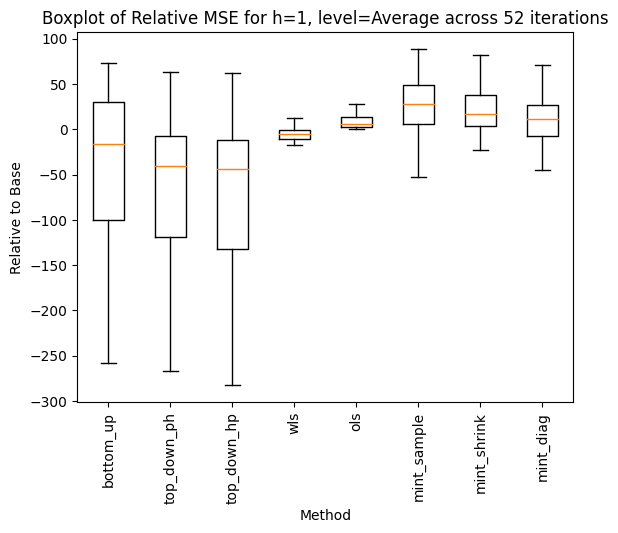

                min   max   mean  median      var
bottom_up   -655.38 73.45 -57.42  -16.75 18234.72
top_down_ph -579.41 62.67 -76.10  -40.76 11426.85
top_down_hp -609.22 62.12 -83.74  -44.27 12639.96
wls          -44.29 12.59  -7.13   -5.39    99.28
ols            0.33 32.25   9.58    6.20    72.96
mint_sample -252.39 88.69  19.81   28.15  2673.86
mint_shrink  -22.80 81.80  20.85   16.33   544.21
mint_diag    -84.86 71.49   7.06   11.25  1139.14


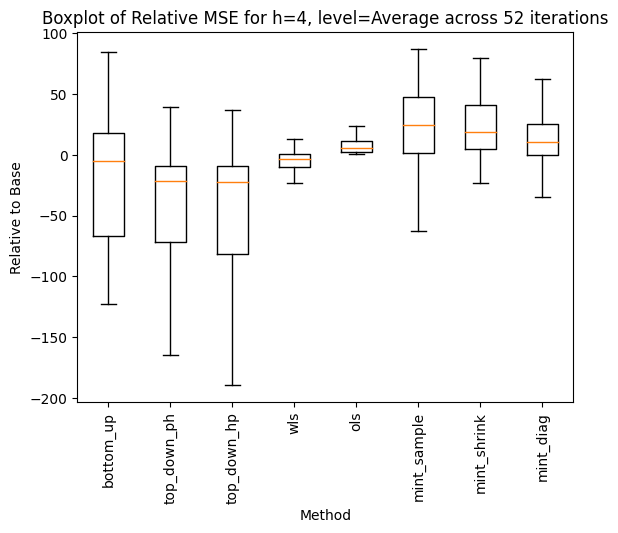

                min   max   mean  median     var
bottom_up   -342.79 85.08 -31.96   -4.62 7428.98
top_down_ph -305.35 39.15 -47.45  -21.09 4326.34
top_down_hp -336.32 36.58 -52.29  -22.55 4977.68
wls          -40.63 12.84  -5.83   -3.60   97.61
ols            0.40 25.82   7.87    6.08   45.60
mint_sample  -97.91 87.22  17.15   24.98 1939.06
mint_shrink  -22.97 79.68  23.35   18.52  494.74
mint_diag    -86.64 67.73   8.48   10.28  954.28


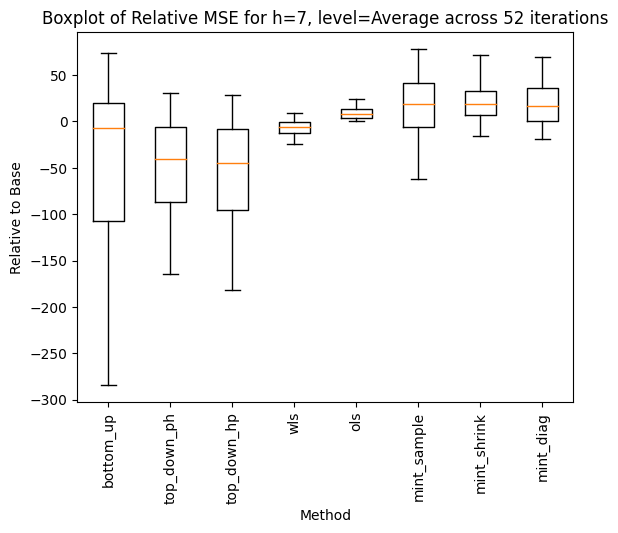

                min   max   mean  median      var
bottom_up   -431.51 74.20 -61.23   -7.60 14871.22
top_down_ph -702.19 31.15 -80.47  -40.11 18264.46
top_down_hp -733.48 28.30 -88.24  -44.79 20051.12
wls          -70.73  8.92  -8.35   -5.79   147.62
ols            0.34 40.24   9.95    8.22    69.80
mint_sample -124.85 78.17  14.21   18.36  1592.26
mint_shrink  -15.70 71.41  22.82   19.27   455.12
mint_diag    -92.51 69.28   9.66   16.56  1465.77


In [ ]:
ddOutputs=ddOutputs_spatial
ddOutputs=ddOutputs_spatio_temporal_td
horizons=[1,4,7]


horizon=7
relative='Base'
level='Average'
iters=int(ddOutputs['bottom_up']['mYhat'].shape[1]/horizon)
metric="MSE"

lMethods=list(ddOutputs.keys())
# lMethods.remove('top_down_ph')
# lMethods.remove('top_down_hp')


### Here we should calculate the loss for each iteration , then plot the loss


plt.figure()
for h in horizons:
    data = []  # To store values for each method
    labels = []  # To store method names as labels
    
    for method in lMethods:
        vValues = np.zeros(iters)
        
        for iter in range(1, iters+1):
            df = getCVResults(h=h, iOoS =horizon, ddOutputs=ddOutputs,  metric=metric, 
                              slices=slices, 
                              iters=iter, 
                              rolling=False, relative=True)[method]
            vValues[iter-1] = df[df.index == level][relative].item()
        
        # Collect all values for the boxplot
        data.append(vValues)
        labels.append(method)
        
        

    # Create a boxplot for the current `h` step-ahead forecast
    plt.boxplot(data, labels=labels,showfliers=False)
    
    plt.xlabel("Method")
    plt.ylabel(f"Relative to {relative}")
    plt.xticks(rotation=90)
    plt.title(f"Boxplot of Relative {metric} of {iters} iterations , for h={h}, level={level}")

    # Show the plot
    plt.show()
    
    #print stats
    mData=np.vstack((np.min(data,axis=1),                 
                np.max(data,axis=1),
                np.mean(data,axis=1),
                np.median(data,axis=1),
                np.var(data,axis=1)
                ))
    dfStats=pd.DataFrame(data=mData.T, columns=['min', 'max', 'mean','median','var'], 
                         index=lMethods
                     )
    print(dfStats)

    



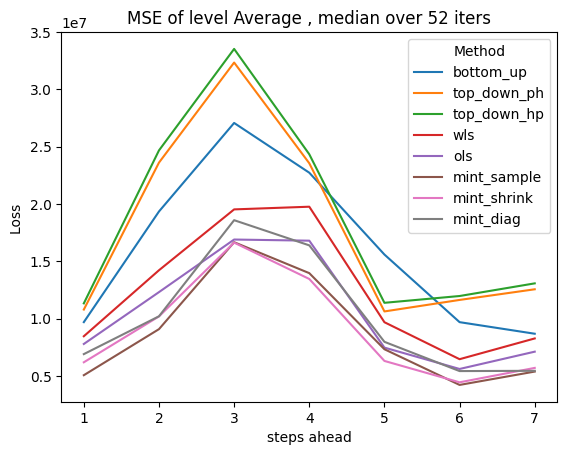

In [ ]:
ddOutputs=ddOutputs_spatial
ddOutputs=ddOutputs_spatio_temporal_td


horizon=7
level='Average'
iters=int(ddOutputs['bottom_up']['mYhat'].shape[1]/horizon)
metric='MSE'

lMethods=list(ddOutputs.keys())
# lMethods.remove('top_down_ph')
# lMethods.remove('top_down_hp')

plt.figure()
for method in lMethods:
    vValues = np.zeros(horizon)
    
    for h in range(1, horizon+1):
        df = getCVResults(h=h, iOoS =horizon, ddOutputs=ddOutputs , metric=metric, slices=slices, 
                          iters=None, 
                          rolling=False, relative=False)[method]
        vValues[h-1] = df[df.index == level].item() 
            
    plt.plot(np.arange(horizon)+1, vValues, label=method)

plt.legend(title="Method")
plt.xlabel("steps ahead")
plt.ylabel(f"Loss ")
plt.title(f"Median {metric} of level {level} , for {iters} iterations")


# Show the plot
plt.show()

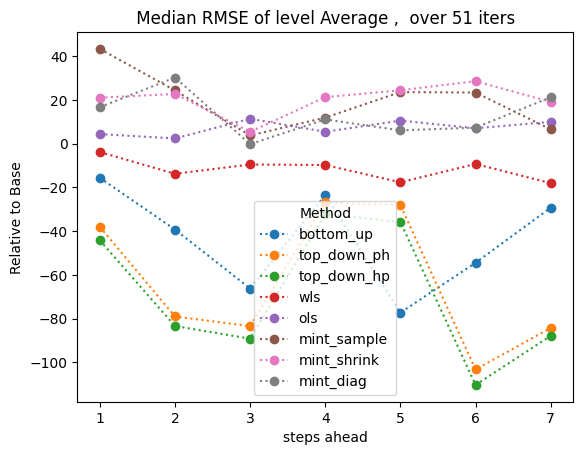

In [ ]:
ddOutputs=ddOutputs_spatial
# ddOutputs=ddOutputs_spatio_temporal_td

horizon=7
relative='Base'
level='Average'
iters=int(ddOutputs['bottom_up']['mYhat'].shape[1]/horizon)
metric='MSE'

lMethods=list(ddOutputs.keys())
# lMethods.remove('top_down_ph')
# lMethods.remove('top_down_hp')
# lMethods.remove('mint_sample')

plt.figure()
for method in lMethods:
    vValues = np.zeros(horizon)
    
    for h in range(1, horizon+1):
        df = getCVResults(h=h, iOoS=horizon, ddOutputs=ddOutputs ,metric=metric, slices=slices, 
                          iters=None, 
                          rolling=False)[method]
        vValues[h-1] = df[df.index == level][relative].item()    
    plt.plot(np.arange(horizon)+1, vValues, label=method,linestyle=':', marker='o')

plt.legend(title="Method")
plt.xlabel("steps ahead")
plt.ylabel(f"Relative to {relative}")
plt.title(f" Median R{metric} of level {level} ,  over {iters} iters ")

# Show the plot
plt.show()




# Tables

In [ ]:

with open(os.getcwd()+'\\outputs\\ddCVOutputsSpatial_prophet_log.pkl', 'rb') as file:
    ddOutputs_spatial = pickle.load(file) 
with open(os.getcwd()+'\\outputs\\ddCVOutputsSpatial_temporal_prophet_td_log.pkl', 'rb') as file:
    ddOutputs_spatio_temporal_td = pickle.load(file) 
with open(os.getcwd()+'\\outputs\\ddCVOutputsSpatial_temporal_prophet_lasso_log.pkl', 'rb') as file:
    ddOutputs_spatio_temporal_lasso = pickle.load(file) 


NameError: name 'dOutputs_Prophet_log' is not defined

In [10]:
metric='MSE'
relative=True
ddOutputs=ddOutputs_spatial
# ddOutputs=ddOutputs_spatio_temporal_td


getCVResults( h=1, iOoS=7, ddOutputs=ddOutputs , metric=metric , slices=slices , rolling=True, relative=relative, iters=None)


Method   bottom_up           top_down_ph           top_down_hp            \
Relative      Base bottom_up        Base bottom_up        Base bottom_up   
Total       -37.58      0.00        0.00     27.31        0.00     27.31   
State       -24.71      0.00      -24.80     -0.07      -33.30     -6.89   
Store         0.53      0.00      -61.19    -62.05      -72.37    -73.28   
Cat.        -42.09      0.00     -156.08    -80.23     -170.42    -90.32   
Dept.         0.00      0.00     -104.01   -104.01     -113.39   -113.39   
Average     -15.60      0.00      -38.03    -19.40      -44.19    -24.73   

Method      wls             ols           mint_sample           mint_shrink  \
Relative   Base bottom_up  Base bottom_up        Base bottom_up        Base   
Total      2.43     29.08  4.62     30.67       16.95     39.63        0.89   
State     -5.54     15.37  3.30     22.46       25.54     40.29       27.54   
Store      9.48      9.00 27.41     27.02       43.47     43.17       45.69   
Cat.     -42.38     -0.21 -8.42     23.69       26.39     48.19       21.79   
Dept.    -27.20    -27.20  7.67      7.67       45.08     45.08       41.09   
Average   -3.82     10.19  4.39     17.29       43.36     51.01       21.05   

Method             mint_diag            
Relative bottom_up      Base bottom_up  
Total        27.96     13.13     36.86  
State        41.90     17.94     34.20  
Store        45.40     31.81     31.45  
Cat.         44.96     -8.26     23.81  
Dept.        41.09     25.25     25.25  
Average      31.71     16.72     27.96